In [1]:
%matplotlib inline
import matplotlib_inline
import warnings
import csv

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
warnings.filterwarnings('ignore')

import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d, interp2d
from scipy.special import *

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Computer Modern Roman"]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 5

# Direct numerical simulation

Data

In [2]:
R = 1.5
H = 6.1
d = 0.015
eps = 0.22
mDot = 7.0

Thermophysical properties (from Van Lew, 2017)

In [3]:
# Fluid
rhof = 1733
muf = 0.0021
cpf = 1550
kf = 0.57

# Solid
rhos = 2640
cps = 1050
ks = 2.5

In [4]:
# velocidades
u = mDot/(eps*rhof*np.pi*R**2)
u0 = eps*u

In [5]:
dt = 3.6
dx = 2.2e-2

t0 = 0
# Four times the experimental discharge time
tf = 2*2*3600
xf = H

t = np.arange(t0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

Nx = len(x) - 1
Nt = len(t) - 1

In [6]:
CFL = dt*u/dx
print('CFL = ', CFL)
print('u = ', u)

CFL =  0.42503454159872484
u =  0.002597433309769985


In [7]:
# Reference temperatures
Tmin = 290 + 273
Tmax = 396 + 273

Tin = Tmin
T0 = 2*Tmin #Tmax

In [8]:
# Initialization
# Tf = np.zeros((Nx+1, Nt+1))
Tf = np.zeros((2*Nx+1, Nt+1))
Ts = np.zeros((Nx+1, Nt+1))

# BCs
Tf[0,:] = Tin

# ICs
Tf[:,0] = T0
Ts[:,0] = T0

In [9]:
# Transport-term coeffs.
alpha = eps*rhof*cpf
gamma = (1 - eps)*rhos*cps

# Diffusive-term coeffs.
beta = eps*kf
betas = (1 - eps)*ks

In [10]:
# Calculation of heat transfer coeff.
Pr = cpf*muf/kf
rchar = eps*d/(4*(1-eps))
G = mDot/(eps*np.pi*R**2)
Re = 4*G*rchar/muf
h = 0.25*0.191*mDot*cpf/(eps*np.pi*R**2)*Re**(-0.278)*Pr**(-2/3)*np.pi*R**2

# Rep = rhof*d*u/muf
# Pr = cpf*muf/kf
# Nu = 0.664*Rep**0.5*Pr**0.5
# a = Nu*kf/d

# # Heat transfer coeff.
# h = a*6*(1-eps)/d

h

399.33071716544214

In [11]:
Lambda = h*H/(rhof*cpf*u*eps)
Lambdas = h*H/(rhos*cps*u*(1-eps))

print(Lambda)
print(Lambdas)

1.5869571696369429
0.4337408426150055


In [12]:
# Matrix terms
p = u*dt/dx

q = beta/alpha*dt/(dx**2)
qs = betas*dt/(gamma*dx**2)

r = h*dt/alpha
rs = h*dt/gamma

In [13]:
# Semi-implicit form of heat transfer term
# diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]

# Explicit form of heat transfer term
diagonals = [np.ones(Nx)*(1 + 2*q + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]

offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
# A[-1,-2] = -2*q - p

diagonals = [np.ones(Nx)*(1 + 2*q + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]
A1 = sp.sparse.diags(diagonals, offsets).toarray()
A1[-1,-2] = -2*q - p

A = sp.sparse.csr_matrix(A)
A1 = sp.sparse.csr_matrix(A1)

In [14]:
# Semi-implicit form of heat transfer term
# diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]

# Explicit form of heat transfer term
diagonals = [np.ones(Nx + 1)*(1 + 2*qs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]

offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)

In [15]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)

bc0[0] = Tin
# bc1[0] = Tin

In [16]:
AA = sp.sparse.block_diag((sp.sparse.linalg.inv(A), sp.sparse.linalg.inv(As)))

In [17]:
AA1 = sp.sparse.linalg.inv(A1)

In [18]:
for i in range(1,Nt+1):
    
#   Semi-implicit form of heat transfer term
#     Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*Tf[i-1,:])
#     Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 + \
#                 r*Ts[i-1,1:])

    # Solve the entire coupled system in matrix form
    TT = np.concatenate([Tf[1:Nx+1,i-1] + (q + p)*bc0 - r*(Tf[1:Nx+1,i-1] - Ts[1:,i-1]),
                         Ts[:,i-1] + rs*(Tf[:Nx+1,i-1] - Ts[:,i-1])])
    sol = AA.dot(TT)

#     Ts[:,i] = sp.sparse.linalg.spsolve(As, Ts[:,i-1] + rs*(Tf[:,i-1] - Ts[:,i-1]))
#     Tf[1:,i] = sp.sparse.linalg.spsolve(A, Tf[1:,i-1] + (q + p)*bc1 - r*(Tf[1:,i-1] - Ts[1:,i-1]))
    
    Tf[1:Nx+1,i] = sol[:Nx]
    Ts[:,i] = sol[Nx:]
    
    bc1[0] = Tf[Nx,i]
    
    Tf[Nx+1:,i] = AA1.dot(Tf[Nx+1:,i-1] + (q + p)*bc1)

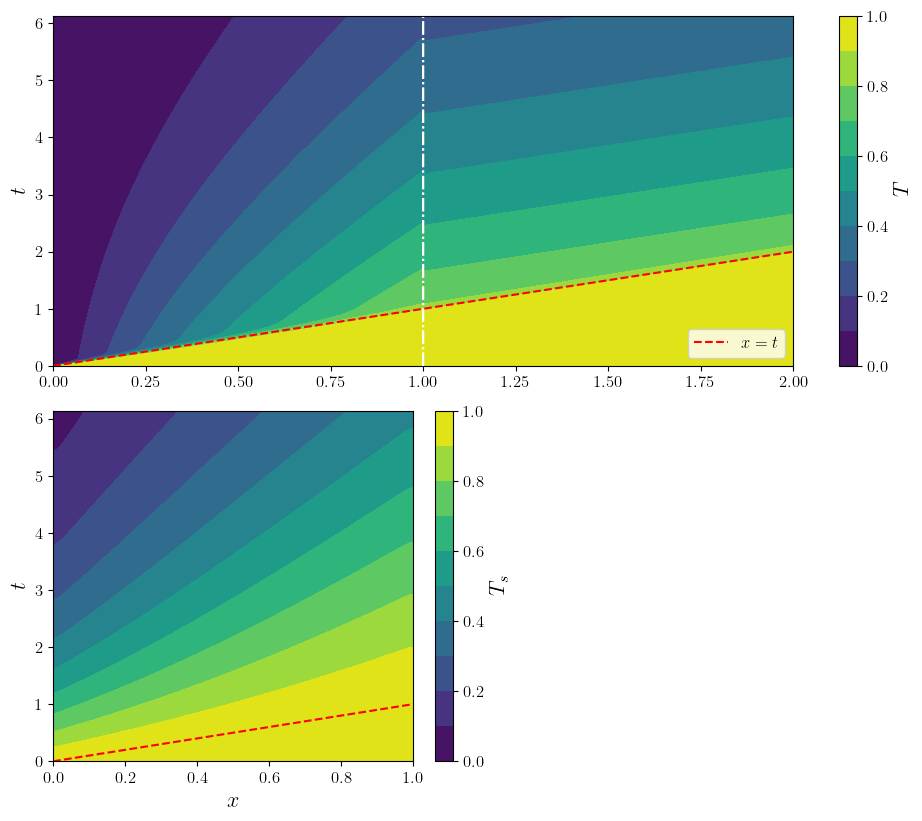

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex='row')
(ax1, ax2) = axs

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)

thetaf = (Tf - Tin)/Tin
thetas = (Ts - Tin)/Tin

xx = np.linspace(0, 2*H, 2*Nx+1)

cs1 = ax1.contourf(xx/H, t*u/H, thetaf.T, 10)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
# ax1.set_box_aspect(1)
ax1.plot(xx/H, xx/H,'r--', label=r'$x = t$')
# ax1.plot(xx/H, -xx/H + 2, 'r--', label=r'$x = t$')

ax1.plot(t*0 + 1, t*u/H,'w-.')
ax1.plot(t*0 + 1, t*u/H,'w-.')

ax1.legend(loc='lower right')
# ax1.set_xlim([0, 1])
# ax1.set_ylim([0, 1])

cs2 = ax2.contourf(x/H, t*u/H, thetas.T, 10)
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
# ax2.set_box_aspect(1)
ax2.plot(x/H, x/H,'r--')
ax2.set_xlim([0, 1])
# ax2.set_ylim([0, 1])

fig.savefig('./figs/DNS_T_vs_x_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

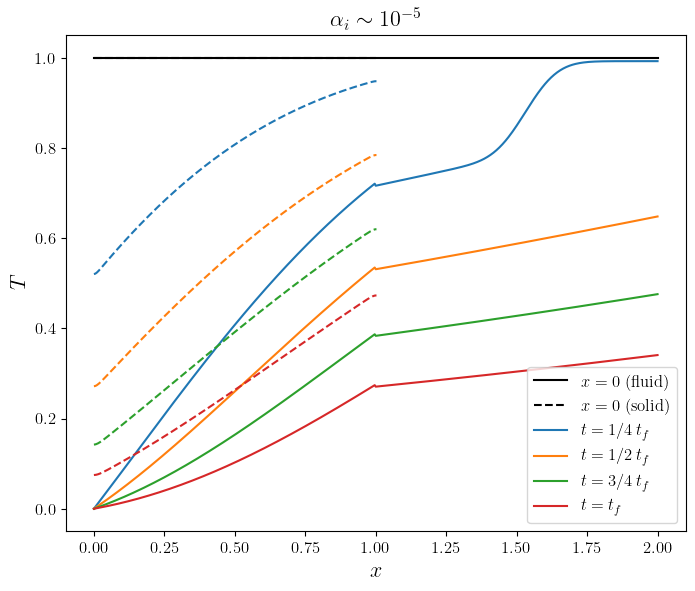

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(xx/H, thetaf[:,0], 'k', x/H, thetas[:,0], 'k--',
         xx/H, thetaf[:,int(1/4*len(t))], 
         xx/H, thetaf[:,int(2/4*len(t))], xx/H, thetaf[:,int(3/4*len(t))], xx/H, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(x/H, thetas[:,int(1/4*len(t))], '--', 
         x/H, thetas[:,int(2/4*len(t))], '--', x/H, thetas[:,int(3/4*len(t))], '--',
         x/H, thetas[:,-1], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$t = 1/4 \,t_f$',
            r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
# ax.set_ylim([-1,0])

plt.title(r'$\alpha_i \sim 10^{-5}$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_x_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

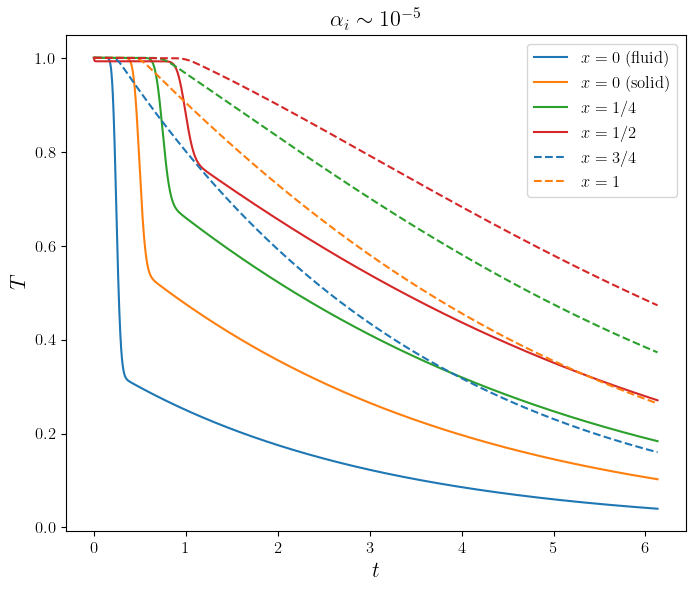

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(t*u/H, thetaf[int(1*len(x)/4),:], t*u/H, thetaf[int(2*len(x)/4),:], 
         t*u/H, thetaf[int(3*len(x)/4),:], t*u/H, thetaf[int(len(x)-1),:])

plt.gca().set_prop_cycle(None)

plt.plot(t*u/H, thetas[int(1*len(x)/4),:], '--',
         t*u/H, thetas[int(2*len(x)/4),:], '--', t*u/H, thetas[int(3*len(x)/4),:], '--',
         t*u/H, thetas[-1,:], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$',
            r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$t$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
# ax.set_ylim([-0.3,0.1])

plt.title(r'$\alpha_i \sim 10^{-5}$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

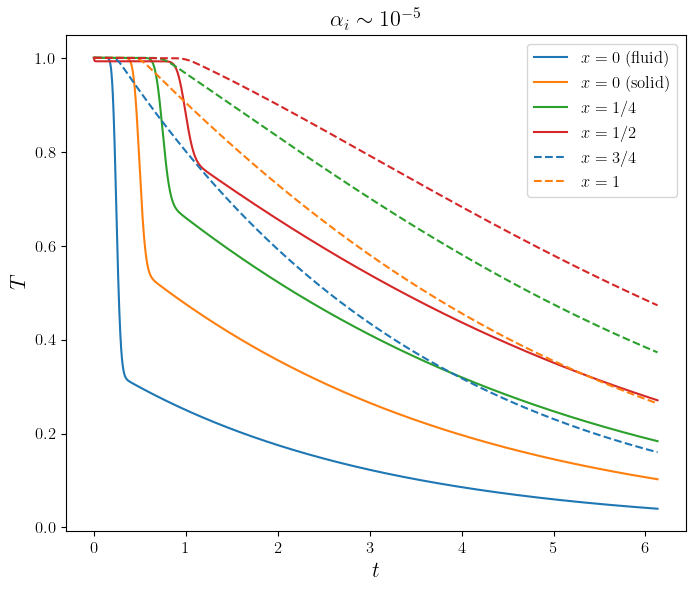

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(t*u/H, thetaf[int(1*len(x)/4),:], t*u/H, thetaf[int(2*len(x)/4),:], 
         t*u/H, thetaf[int(3*len(x)/4),:], t*u/H, thetaf[int(len(x)-1),:])

plt.gca().set_prop_cycle(None)

plt.plot(t*u/H, thetas[int(1*len(x)/4),:], '--',
         t*u/H, thetas[int(2*len(x)/4),:], '--', t*u/H, thetas[int(3*len(x)/4),:], '--',
         t*u/H, thetas[-1,:], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$',
            r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$t$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
# ax.set_ylim([-0.3,0.1])

plt.title(r'$\alpha_i \sim 10^{-5}$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

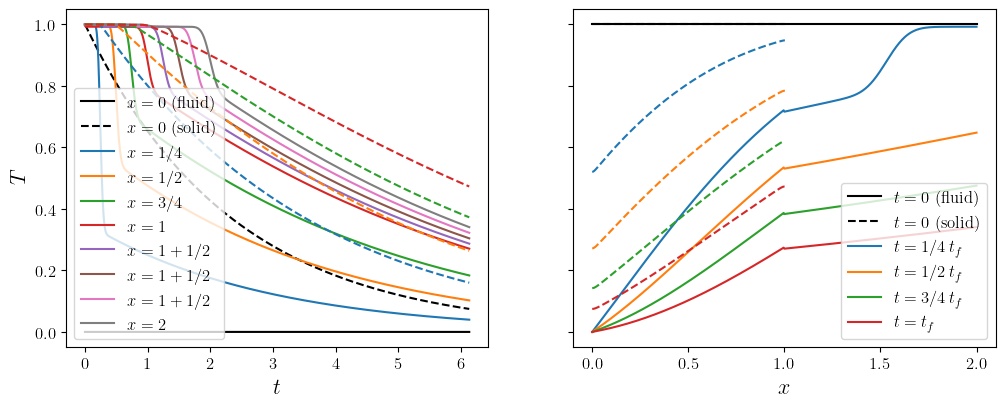

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,12), sharey='all')
(ax1, ax2) = axs

ax1.plot(t*u/H, thetaf[0,:]*0, 'k-', t*u/H, thetas[0,:], 'k--',
         t*u/H, thetaf[int(1/4*len(x)),:],
         t*u/H, thetaf[int(1/2*len(x)),:],
         t*u/H, thetaf[int(3/4*len(x)),:],
         t*u/H, thetaf[int(len(x)-1),:],
         t*u/H, thetaf[int(len(x) + 1/4*len(x)),:],
         t*u/H, thetaf[int(len(x) + 2/4*len(x)),:],
         t*u/H, thetaf[int(len(x) + 3/4*len(x)),:],
         t*u/H, thetaf[int(len(xx)-1),:])

ax1.set_prop_cycle(None)

ax1.plot(t*u/H, thetas[int(1/4*len(x)),:], '--',
         t*u/H, thetas[int(1/2*len(x)),:], '--',
         t*u/H, thetas[int(3/4*len(x)),:], '--',
         t*u/H, thetas[-1,:], '--')

ax1.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$', r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$',
            r'$x = 1 + 1/2$', r'$x = 1 + 1/2$', r'$x = 1 + 1/2$', r'$x = 2$'])
ax1.set_box_aspect(0.8)
ax1.set_xlabel(r'$t$', fontsize=16)
ax1.set_ylabel(r'$T$', fontsize=16)

##

ax2.plot(xx/H, thetaf[:,0], 'k', x/H, thetas[:,0], 'k--', xx/H, thetaf[:,int(1/4*len(t))], 
         xx/H, thetaf[:,int(2/4*len(t))], xx/H, thetaf[:,int(3/4*len(t))], xx/H, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

ax2.plot(x/H, thetas[:,int(1/4*len(t))], '--', 
         x/H, thetas[:,int(2/4*len(t))], '--',
         x/H, thetas[:,int(3/4*len(t))], '--',
         x/H, thetas[:,-1], '--')

ax2.legend([r'$t = 0$ (fluid)', r'$t = 0$ (solid)', r'$t = 1/4 \,t_f$', r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'])
ax2.set_box_aspect(0.8)
ax2.set_xlabel(r'$x$', fontsize=16)


fig.savefig('./figs/DNS_T_vs_x_vs_t_subplot_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

# Method of Characteristics for extended nonporous domain

In [24]:
print(Lambda)
print(Lambdas)

1.5869571696369429
0.4337408426150055


In [25]:
# Malla características
CFL = dt*u/dx

dtc = dt*u/H
dxc = dtc

xc = np.arange(0, 1 + dxc, dxc)
xc1 = np.arange(0, 2 + dxc, dxc)
tc = np.arange(0, tf*u/H + dtc, dtc)

In [26]:
# Discretización
xvc, tvc = np.meshgrid(xc, tc, indexing='ij')
xvc1, tvc1 = np.meshgrid(xc1, tc, indexing='ij')

Cp = xvc*0
Cn = xvc*0

Tsc = xvc*0 + 1
Tfc = xvc1*0 + 0

# ICs
Tfc[:,0] = 0
Tsc[:,0] = 1

# BCs
Tfc[0,:] = 0 #(Tin - T0)/T0

# Valor inicial de las características
Cp[:,0] = tc[0] + xc
Cn[:,0] = xc

Matrix assembly

In [27]:
A = [[1 + 0.5*Lambda*dtc, -0.5*Lambda*dtc],
    [-0.5*Lambdas*dtc, 1 + 0.5*Lambdas*dtc]]
Ainv = np.linalg.inv(A)

In [28]:
# Numerical integration by using explicit Euler
for j in range(1,len(tc)): 
    Cp[:,j] = tc[j] + xc
    Cn[:,j] = xc
    
    if tc[j] <= 1:
        for i in range(1,len(xc1)):
            if i <= int(len(xc1)/2) + 1:
                Tfc[i,j] = Tfc[i-1,j-1]
    else:
        for i in range(1,len(xc1)):
            if i <= int(len(xc1)/2) + 1:
                # Solución de ODEs sobre las características
                Tfc[i,j], Tsc[i-1,j] = Ainv.dot([-0.5*Lambda*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tfc[i-1,j-1],
                                                  0.5*Lambdas*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tsc[i-1,j-1]])
            else:
                # Tfc[i,j] = -Lambda*eps*Tfc[i-1,j-1]*dtc + Tfc[i-1,j-1]
                Tfc[i,j] = Tfc[i-1,j-1]
        

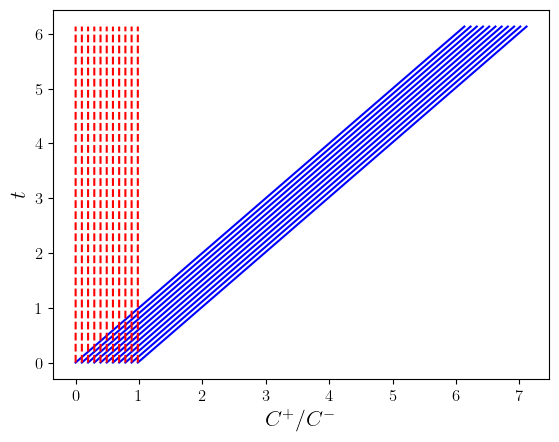

In [29]:
fig, axs = plt.subplots()

axs.plot(Cp[::64,:].T, tc, 'b-')
axs.plot(Cn[::64,:].T, tc, 'r--')

axs.set_ylabel(r'$t$', fontsize=16)
axs.set_xlabel(r'$C^+/C^-$', fontsize=16)

fig.savefig('./figs/characteristics_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

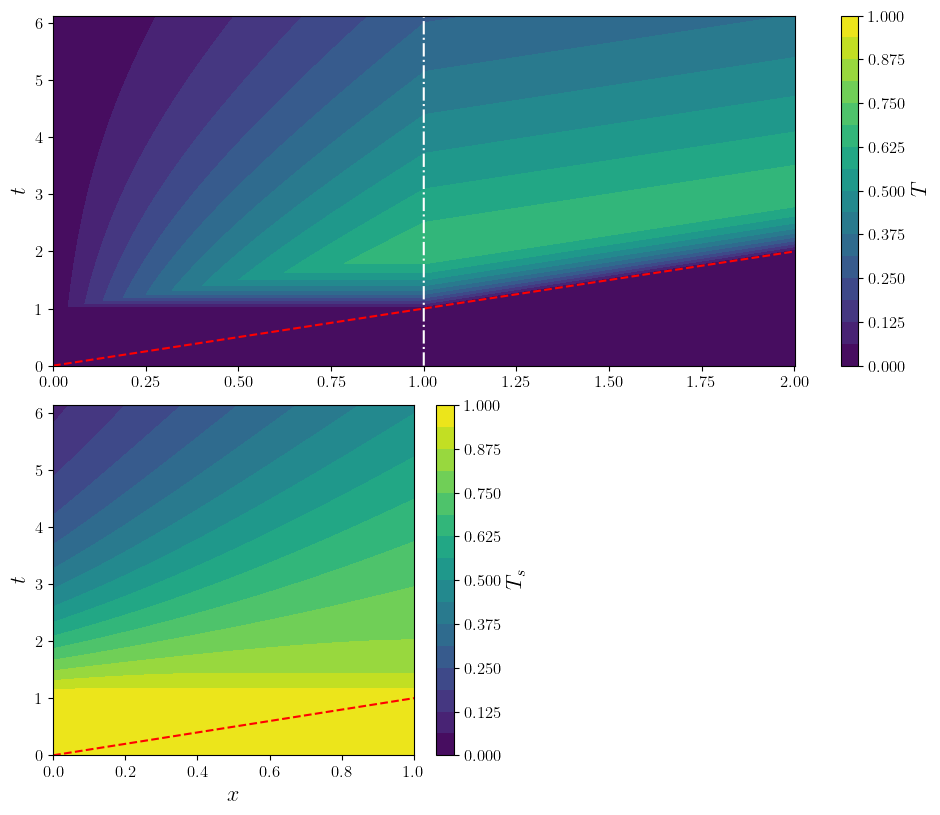

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex='row')
(ax1, ax2) = axs

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)

cs1 = ax1.contourf(xvc1, tvc1, Tfc, np.linspace(0, 1, 17))
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
# ax1.set_box_aspect(1)
ax1.plot(xc1, xc1,'r--', label=r'$x = t$')
ax1.plot(tc*0 + 1, tc,'w-.', label=r'$x = 1$')
# ax1.legend(loc='lower right')
#ax1.set_xlim([0, 1])
#ax1.set_ylim([0, 1])

cs2 = ax2.contourf(xvc, tvc, Tsc, np.linspace(0, 1, 17))
plt.tight_layout()
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
# ax2.set_box_aspect(1)
ax2.plot(xc, xc,'r--', label=r'$x = t$')
ax2.set_xlim([0, 1])
#ax2.set_ylim([0, 1])
ax2.set_xlabel(r'$x$', fontsize=16)

fig.savefig('./figs/char_T_vs_x_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

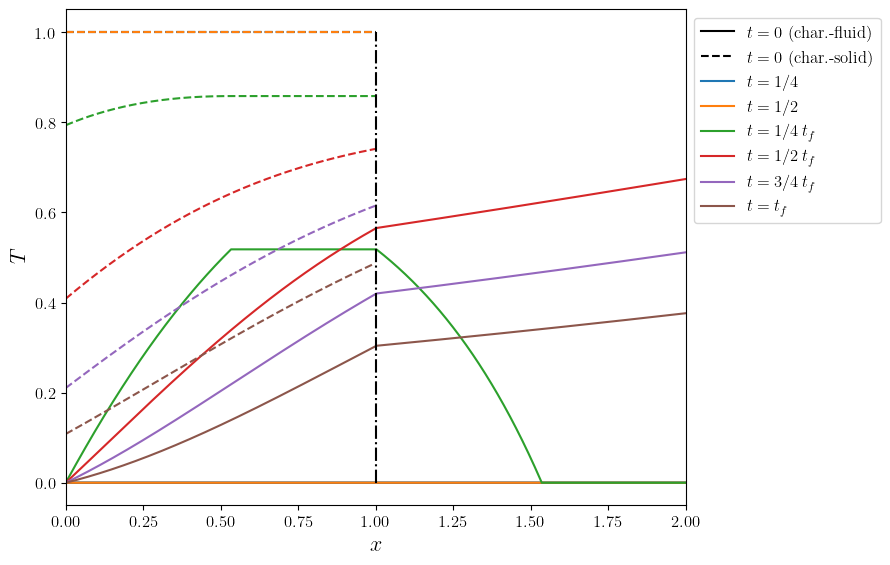

In [31]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(xc1, Tfc[:,0], 'k-', xc, Tsc[:,0], 'k--',
         xc1, Tfc[:,int(0.25/dtc)], xc1, Tfc[:,int(0.5/dtc)],
         xc1, Tfc[:,int(1/4*len(tc))], xc1, Tfc[:,int(2/4*len(tc))],
         xc1, Tfc[:,int(3/4*len(tc))], xc1, Tfc[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(xc[:-2], Tsc[:-2,int(0.25/dtc)], '--', xc[:-2], Tsc[:-2,int(0.5/dtc)], '--',
         xc[:-2], Tsc[:-2,int(1/4*len(tc))], '--', xc[:-2], Tsc[:-2,int(2/4*len(tc))], '--',
         xc[:-2], Tsc[:-2,int(3/4*len(tc))], '--', xc[:-2], Tsc[:-2,-1], '--')

plt.plot(xc*0 + 1, xc, 'k-.')

plt.xlim([0, xc1[-1]])

plt.legend([r'$t = 0$ (char.-fluid)', r'$t = 0$ (char.-solid)',
            r'$t = 1/4$',r'$t = 1/2$',r'$t = 1/4 \,t_f$',
            r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
fig.savefig('./figs/char_Tf_Ts_vs_x_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

# Profiles comparison: DNS vs. characteristics for nonporous extended domain

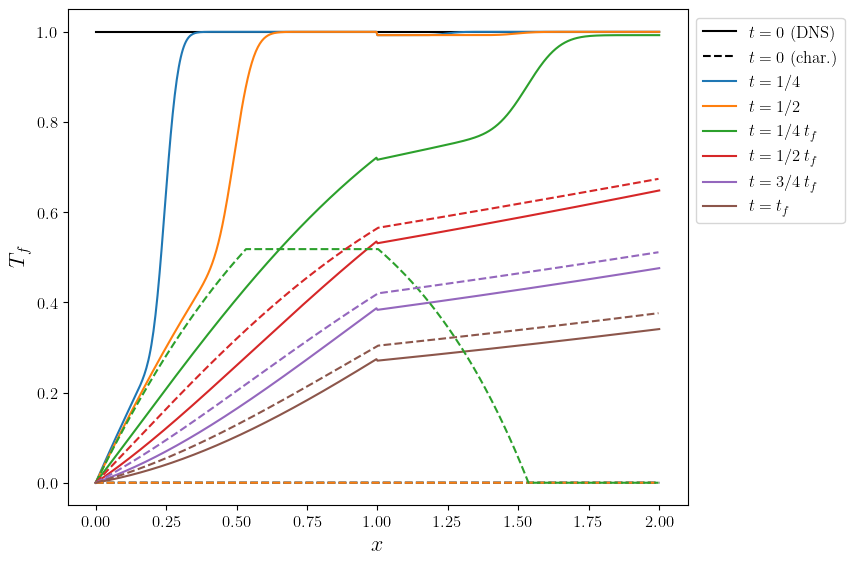

In [32]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(xx/H, thetaf[:,0], 'k',
         xc1, Tfc[:,0], 'k--',
         xx/H, thetaf[:,int(0.25*H/u/dt)],
         xx/H, thetaf[:,int(0.50*H/u/dt)],
         xx/H, thetaf[:,int(1/4*len(t))],
         xx/H, thetaf[:,int(2/4*len(t))],
         xx/H, thetaf[:,int(3/4*len(t))],
         xx/H, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(xc1[:-2], Tfc[:-2,int(0.25/dtc)], '--',
         xc1[:-2], Tfc[:-2,int(0.50/dtc)], '--',
         xc1[:-2], Tfc[:-2,int(1/4*len(tc))], '--',
         xc1[:-2], Tfc[:-2,int(2/4*len(tc))], '--',
         xc1[:-2], Tfc[:-2,int(3/4*len(tc))], '--',
         xc1[:-2], Tfc[:-2,-1], '--')

# plt.xlim([-0.01, 0.04])
# plt.ylim([0.75, 1.125])

plt.legend([r'$t = 0$ (DNS)', r'$t = 0$ (char.)',
            r'$t = 1/4$', r'$t = 1/2$',
            r'$t = 1/4 \,t_f$', r'$t = 1/2 \,t_f$',
            r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T_f$', fontsize=16)
fig.savefig('./figs/DNS_vs_characteristics_fluid_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

In [33]:
# Interpolation
f = interp2d(xx, t, thetaf.T, kind='linear')
g = interp2d(x, t, thetas.T, kind='linear')
thetafq = f(xc*H, t)
thetasq = g(xc*H, t)

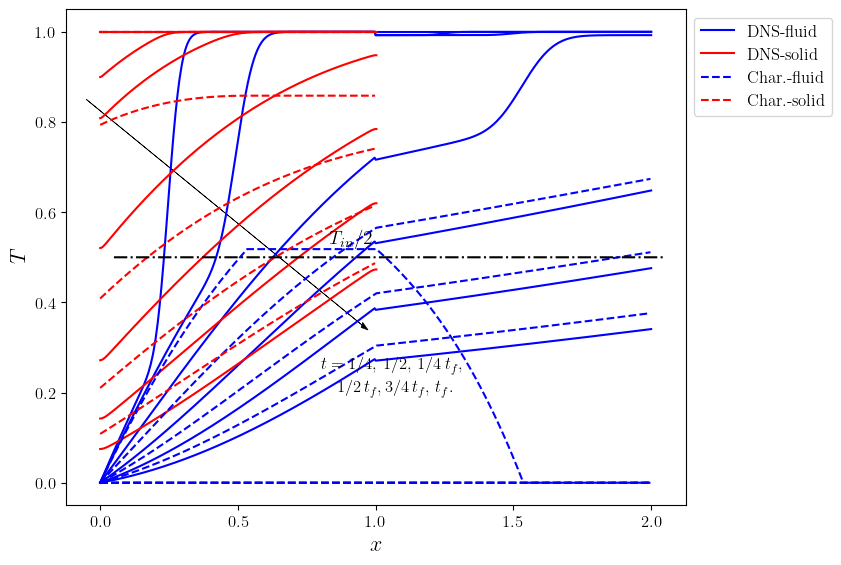

In [34]:
# Profiles intersection
# idx0 = np.argwhere(np.diff(np.sign(thetafq[n00,:] - Tfc[:,n00]))).flatten()[-1]
# idx1 = np.argwhere(np.diff(np.sign(thetafq[nt0p5h,:] - Tfc[:,nt0p5h]))).flatten()[-1]
# idx2 = np.argwhere(np.diff(np.sign(thetafq[nt1h,:] - Tfc[:,nt1h]))).flatten()[-1]
# idx3 = np.argwhere(np.diff(np.sign(thetafq[nt1p5h,:] - Tfc[:,nt1p5h]))).flatten()[-1]
# idx4 = np.argwhere(np.diff(np.sign(thetafq[nt2h,:] - Tfc[:,nt2h]))).flatten()[-1]

fig, ax = plt.subplots(figsize=(8,8))

# DNS - fluid
plt.plot(xx/H, thetaf[:,0], 'b-')
plt.plot(xc1, Tfc[:,0], 'b--')
plt.plot(x/H, thetas[:,0], 'r-')
plt.plot(xc[:-2], Tsc[:-2,0], 'r--')

plt.plot(xx/H, thetaf[:,int(0.25*H/u/dt)], 'b-', label='DNS-fluid')
plt.plot(xx/H, thetaf[:,int(0.50*H/u/dt)], 'b-')
plt.plot(xx/H, thetaf[:,int(1/4*len(t))], 'b-')
plt.plot(xx/H, thetaf[:,int(2/4*len(t))], 'b-')
plt.plot(xx/H, thetaf[:,int(3/4*len(t))], 'b-')
plt.plot(xx/H, thetaf[:,-1], 'b-')

# DNS - solid
plt.plot(x/H, thetas[:,int(0.25*H/u/dt)], 'r-')
plt.plot(x/H, thetas[:,int(0.50*H/u/dt)], 'r-')
plt.plot(x/H, thetas[:,int(1/4*len(t))], 'r-', label='DNS-solid')
plt.plot(x/H, thetas[:,int(2/4*len(t))], 'r-')
plt.plot(x/H, thetas[:,int(3/4*len(t))], 'r-')
plt.plot(x/H, thetas[:,-1], 'r-')

# Char. - fluid
plt.plot(xc1[:-2], Tfc[:-2,int(0.25/dtc)], 'b--')
plt.plot(xc1[:-2], Tfc[:-2,int(0.50/dtc)], 'b--')
plt.plot(xc1[:-2], Tfc[:-2,int(1/4*len(tc))], 'b--', label='Char.-fluid')
plt.plot(xc1[:-2], Tfc[:-2,int(2/4*len(tc))], 'b--')
plt.plot(xc1[:-2], Tfc[:-2,int(3/4*len(tc))], 'b--')
plt.plot(xc1[:-2], Tfc[:-2,-1], 'b--')

# Char. - solid
plt.plot(xc[:-2], Tsc[:-2,int(0.25/dtc)], 'r--')
plt.plot(xc[:-2], Tsc[:-2,int(0.50/dtc)], 'r--')
plt.plot(xc[:-2], Tsc[:-2,int(1/4*len(tc))], 'r--', label='Char.-solid')
plt.plot(xc[:-2], Tsc[:-2,int(2/4*len(tc))], 'r--')
plt.plot(xc[:-2], Tsc[:-2,int(3/4*len(tc))], 'r--')
plt.plot(xc[:-2], Tsc[:-2,-1], 'r--')

# plt.plot(xc[idx0], thetafq[n00,idx0], 'ko', xc[idx1], thetafq[nt0p5h,idx1], 'ko', xc[idx2], thetafq[nt1h,idx2], 'ko',
#          xc[idx3], thetafq[nt1p5h,idx3], 'ko', xc[idx4], thetafq[nt2h,idx4], 'ko')


# Average T
plt.plot(xc1 + 0.05, xc1*0 + 0.5, 'k-.')

# Cosmetics
plt.text(0.83, 0.53, r'$T_{in}/2$', fontsize=14)
plt.arrow(-0.05, 0.85, 1, -0.5, width=0.0001, color='k', head_width=0.0125, head_length=0.025, lw=0.5)
plt.text(0.80, 0.25, r'$t = 1/4,\, 1/2,\,1/4\,t_f,$', fontsize=12)
plt.text(0.865, 0.20, r'$1/2\,t_f,3/4\,t_f,\,t_f.$', fontsize=12)

plt.xlim([-0.125, xc1[-1] + 0.125])

# plt.legend([r'$t = 0$ '+ r'(DNS)', r'$t = 0$ ' + r'(char.)'], bbox_to_anchor=(1, 1), loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)

fig.savefig('./figs/DNS_vs_characteristics_all_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()


# Theoretical solution by Schumann (1929) -- in process

The theoretical solution due to Schumann explores the temperatures evolution in the range at $0 < y < 10$ and $0 < z < 10$. According to our natural coordinates $x$ and $t$, the former are related as

$y = \Lambda x$, so that $0 < x < 10/\Lambda \sim \mathcal{O}(10^{-2})$

$z = \Lambda_s (t - x)$, equivalent to $0 < t < 10(1/\Lambda + 1/\Lambda_s) \sim \mathcal{O}(10^{-1})$.

Otherwise, if we maintain the scales in $y$ and $z$ to fit these of $x$ and $t$, the heat transfer coefficients are
in consequence

$\Lambda = 1$, and $\Lambda_s >> 1$.

In [35]:
y = Lambda*xvc
z = Lambdas*(tvc - xvc)

TypeError: Shapes of x (654, 4001) and z (1306, 4001) do not match

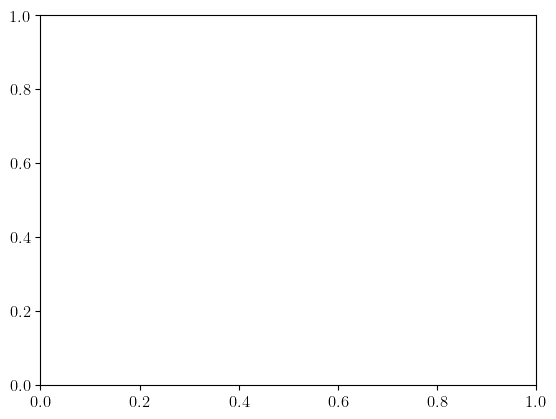

In [36]:
fig, ax = plt.subplots()

cs1 = ax.contourf(z, y, Tfc, np.linspace(Tfc.min(), Tfc.max(), 16))
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$y$', fontsize=16)
ax.set_box_aspect(1)
ax.plot(z*0, y, 'r--', label=r'$z = 0$')# ax1.legend(loc='lower right')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(z[:,int(1/dy)], Tfc[:,int(1/dy)]*T0/(Tin - T0), label=r'$y = 1$')
plt.plot(z[:,int(3/dy)], Tfc[:,int(3/dy)]*T0/(Tin - T0), label=r'$y = 3$')
plt.plot(z[:,int(5/dy)], Tfc[:,int(5/dy)]*T0/(Tin - T0), label=r'$y = 5$')
plt.plot(z[:,int(7/dy)], Tfc[:,int(7/dy)]*T0/(Tin - T0), label=r'$y = 7$')
plt.plot(z[:,int(10/dy)], Tfc[:,int(10/dy)]*T0/(Tin - T0), label=r'$y = 10$')

plt.xlim([0,10])
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$T$', fontsize=16)
plt.legend()
plt.show()

In [ ]:
k2 = h/(rhof*cpf*eps)
k1 = h/(rhos*cps*(1-eps))

dh = 0.01

Y = np.arange(0, 10+dh, dh)
Z = np.arange(0, 10+dh, dh)
z, y = np.meshgrid(Z, Y)

# y = Lambda*xvc
# z = Lambdas*(tvc - xvc)

a = np.arange(0+dh, 100+dh, dh)

In [ ]:
n = 20

M0 = sum(a**i/(np.math.factorial(i)**2) for i in range(n))
M0_ = jn(0,2j*sp.sqrt(a))

In [ ]:
plt.plot(a, M0, a, M0_)
plt.show()

In [ ]:
def schumann(y, z):
    Tss = np.exp(-y - z) * (
        z**9 * (1/362880 + (y * z)/3628800) +
        z**8 * (1/40320 + (y * z)/362880 + (y**2 * z**2)/7257600) +
        z**7 * (1/5040 + (y * z)/40320 + (y**2 * z**2)/725760 + (y**3 * z**3)/21772800) +
        z**6 * (1/720 + (y * z)/5040 + (y**2 * z**2)/80640 + (y**3 * z**3)/2177280 + (y**4 * z**4)/87091200) +
        z**5 * (1/120 + (y * z)/720 + (y**2 * z**2)/10080 + (y**3 * z**3)/241920 + (y**4 * z**4)/8709120 + (y**5 * z**5)/435456000) +
        z**4 * (1/24 + (y * z)/120 + (y**2 * z**2)/1440 + (y**3 * z**3)/30240 + (y**4 * z**4)/967680 + (y**5 * z**5)/43545600 + (y**6 * z**6)/2612736000) +
        z**3 * (1/6 + (y * z)/24 + (y**2 * z**2)/240 + (y**3 * z**3)/4320 + (y**4 * z**4)/120960 + (y**5 * z**5)/4838400 + (y**6 * z**6)/261273600 + (y**7 * z**7)/18289152000) +
        z**2 * (1/2 + (y * z)/6 + (y**2 * z**2)/48 + (y**3 * z**3)/720 + (y**4 * z**4)/17280 + (y**5 * z**5)/604800 + (y**6 * z**6)/29030400 + (y**7 * z**7)/1828915200 + (y**8 * z**8)/146313216000) +
        z * (1 + (y * z)/2 + (y**2 * z**2)/12 + (y**3 * z**3)/144 + (y**4 * z**4)/2880 + (y**5 * z**5)/86400 + (y**6 * z**6)/3628800 + (y**7 * z**7)/203212800 + (y**8 * z**8)/14631321600 + (y**9 * z**9)/1316818944000)
    )
    
    Tff = np.exp(-y - z) * (
        1 + y * z + (y**2 * z**2)/4 + (y**3 * z**3)/36 + (y**4 * z**4)/576 + (y**5 * z**5)/14400 +
        (y**6 * z**6)/518400 + (y**7 * z**7)/25401600 + (y**8 * z**8)/1625702400 + (y**9 * z**9)/131681894400 +
        (y**10 * z**10)/13168189440000 +
        z**9 * (1/362880 + (y * z)/3628800) +
        z**8 * (1/40320 + (y * z)/362880 + (y**2 * z**2)/7257600) +
        z**7 * (1/5040 + (y * z)/40320 + (y**2 * z**2)/725760 + (y**3 * z**3)/21772800) +
        z**6 * (1/720 + (y * z)/5040 + (y**2 * z**2)/80640 + (y**3 * z**3)/2177280 + (y**4 * z**4)/87091200) +
        z**5 * (1/120 + (y * z)/720 + (y**2 * z**2)/10080 + (y**3 * z**3)/241920 + (y**4 * z**4)/8709120 + (y**5 * z**5)/435456000) +
        z**4 * (1/24 + (y * z)/120 + (y**2 * z**2)/1440 + (y**3 * z**3)/30240 + (y**4 * z**4)/967680 + (y**5 * z**5)/43545600 + (y**6 * z**6)/2612736000) +
        z**3 * (1/6 + (y * z)/24 + (y**2 * z**2)/240 + (y**3 * z**3)/4320 + (y**4 * z**4)/120960 + (y**5 * z**5)/4838400 + (y**6 * z**6)/261273600 + (y**7 * z**7)/18289152000) +
        z**2 * (1/2 + (y * z)/6 + (y**2 * z**2)/48 + (y**3 * z**3)/720 + (y**4 * z**4)/17280 + (y**5 * z**5)/604800 + (y**6 * z**6)/29030400 + (y**7 * z**7)/1828915200 + (y**8 * z**8)/146313216000) +
        z * (1 + (y * z)/2 + (y**2 * z**2)/12 + (y**3 * z**3)/144 + (y**4 * z**4)/2880 + (y**5 * z**5)/86400 + (y**6 * z**6)/3628800 + (y**7 * z**7)/203212800 + (y**8 * z**8)/14631321600 + (y**9 * z**9)/1316818944000)
    )
    
    return Tss, Tff

In [ ]:
Tss, Tff = schumann(y, z)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,8), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(z, y, Tff, 16)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
ax1.set_box_aspect(1)
# ax1.legend(loc='lower right')
ax1.set_xlim([0, 1])
#ax1.set_ylim([0, 1])

cs2 = ax2.contourf(z, y, Tss, 16)
plt.tight_layout()
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
ax2.set_box_aspect(1)
ax2.set_xlim([0, 1])
#ax2.set_ylim([0, 1])

# fig.savefig('char_T_vs_x_vs_t.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(Z, Tss[::100,:].T)

# plt.text(0.8, -0.075, r'$T_{in}/2$', fontsize=14)

plt.xlim([0, 10])
# plt.ylim([0, 1])

# plt.legend([r'$t = 0$ '+ r'(DNS)', r'$t = 0$ ' + r'(char.)', r'$t = {:.3f}$'.format(np.round(n00*dt*H/u/tf, 3)) + r'$\, t_f$', 
#             r'$t = 1/4 \,t_f$',
#             r'$t = 2/4 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$z$', fontsize=16)
ax.set_ylabel(r'$T_s/T_{in}$', fontsize=16)

plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(Z, Tff[100::100,:].T)

# plt.text(0.8, -0.075, r'$T_{in}/2$', fontsize=14)

plt.xlim([0, 10])
plt.ylim([0, 1])

# plt.legend([r'$t = 0$ '+ r'(DNS)', r'$t = 0$ ' + r'(char.)', r'$t = {:.3f}$'.format(np.round(n00*dt*H/u/tf, 3)) + r'$\, t_f$', 
#             r'$t = 1/4 \,t_f$',
#             r'$t = 2/4 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$z$', fontsize=16)
ax.set_ylabel(r'$T/T_{in}$', fontsize=16)

plt.show()